## Import libraries

In [36]:
# import libraries
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import pickle as pkl

### Read and preprocess data

In [37]:
# read csv
train = pd.read_csv('data/train_test/train.csv', header = 0)
test = pd.read_csv('data/train_test/test.csv', header = 0)

# split X and y
y_train = train['M']
X_train = train.drop(columns = ['M'])

y_test = test['M']
X_test = test.drop(columns = ['M'])


# data normalization
from sklearn.preprocessing import StandardScaler

# list for cols to scale
cols_to_scale = ['Fe','S1','S2','S3','S4','Ni','Co','Cr','Mn','Se','S','Te']

#create and fit scaler using train data
scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])

#scale trained data
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])

# scale test data
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# save standard scaler
pkl.dump(scaler, open('models/standard_scaler/scaler.pkl', 'wb'))

In [38]:
# define k-fold object
kfold = KFold(n_splits=10, shuffle=True, random_state=100)

## Stacking 

## Prepare data for stacking

In [ ]:
# initialize empty dataframe
results = pd.DataFrame()

#early stopping
es = EarlyStopping(patience=15, monitor='val_loss', mode = 'min')


# initialize 
output_svm = []
output_rf = []
output_ANN = []
output_xgb = []
output_knn = []
output_dt = []
target = []
for train, val in kfold.split(X_train):
        X_train_small, y_train_small = X_train.iloc[train], y_train.iloc[train]
        X_val, y_val = X_train.iloc[val], y_train.iloc[val]

        # model-1
        svr = SVR(C=12)
        svr.fit(X_train_small,y_train_small)
        y_pred_svm = svr.predict(X_val)
        
        # model-2
        rf_clf = RandomForestRegressor(n_estimators=500, min_samples_split = 13)
        rf_clf.fit(X_train_small,y_train_small)
        y_pred_rf = rf_clf.predict(X_val)
        
        # model-3
        knn_clf = KNeighborsRegressor()
        knn_clf.fit(X_train_small,y_train_small)
        y_pred_knn = knn_clf.predict(X_val)
        
        # model-4
        xgb_clf = GradientBoostingRegressor()
        xgb_clf.fit(X_train_small, y_train_small)
        y_pred_xgb = xgb_clf.predict(X_val)
        
        # model-5
        dt_clf = DecisionTreeRegressor()
        dt_clf.fit(X_train_small, y_train_small)
        y_pred_dt = dt_clf.predict(X_val)
        
        # model-6
        # define model
        model = Sequential()
        model.add(Dense(256, activation= 'relu', input_shape = (12,))) #input shape = X_train[0].shape
        model.add(Dense(64, activation= 'relu'))
        model.add(Dense(1))
        model.compile(optimizer= Adam(learning_rate = 0.001), loss='mse')

        # early stopping
        callback = EarlyStopping(patience=7, monitor='val_loss', mode = 'min')
        history = model.fit(X_train_small,y_train_small, epochs = 500,  batch_size=256, verbose=1, validation_data=(X_val, y_val), callbacks = [es])
        y_pred_ann = model.predict(X_val)
        y_pred_ann = y_pred_ann.reshape(y_pred_ann.shape[0],)
        
        #append results
        output_svm.extend(y_pred_svm)
        output_rf.extend(y_pred_rf)
        output_ANN.extend(y_pred_ann)
        output_xgb.extend(y_pred_xgb)
        output_knn.extend(y_pred_knn)
        output_dt.extend(y_pred_dt)
        target.extend(y_val)

In [ ]:
# combine predictions
results['svm'] = output_svm
results['rf'] = output_rf
results['ann'] = output_ANN
results['knn'] = output_knn
results['xgb'] = output_xgb
results['dt'] = output_dt
results['target'] = target

In [88]:
X_train_stacking = results[['rf','svm', 'knn', 'ann', 'dt', 'xgb']]
y_train_stacking = results['target']

### Meta classifier CV

In [ ]:
# Gradient Boosting

print("XGB")
print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
reg = GradientBoostingRegressor()

score = cross_val_score(reg, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_squared_error')
print("Scores: ",score,"\n\nNegative Mean Square Error:",score.mean())

print("---------------------")
# R2 Error
score = cross_val_score(reg, X_train_stacking, y_train_stacking, cv= 10)
print("Scores: ",score,"\n\nR2 Mean Score:",score.mean())

# MAE
print("---------------------")
score = cross_val_score(reg, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_absolute_error')
print("Scores: ",score,"\n\nMean Absolute Error:",score.mean())

# SVR
svr = SVR()

print("SVR")
print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

score = cross_val_score(svr, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_squared_error')
print("Scores: ",score,"\n\nNegative Mean Square Error:",score.mean())
print("---------------------")

# R2 Error
score = cross_val_score(svr, X_train_stacking, y_train_stacking, cv= 10)
print("Scores: ",score,"\n\nR2 Mean Score:",score.mean())

# MAE
print("---------------------")
score = cross_val_score(svr, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_absolute_error')
print("Scores: ",score,"\n\nMean Absolute Error:",score.mean())


# LR
lr = LinearRegression()
score = cross_val_score(lr, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_squared_error')
print("Scores: ",score,"\n\nNegative Mean Square Error:",score.mean())
print("---------------------")

# R2 Error
score = cross_val_score(lr, X_train_stacking, y_train_stacking, cv= 10)
print("Scores: ",score,"\n\nR2 Mean Score:",score.mean())

# MAE
print("---------------------")
score = cross_val_score(lr, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_absolute_error')
print("Scores: ",score,"\n\nMean Absolute Error:",score.mean())


# rf
rf = RandomForestRegressor()
score = cross_val_score(rf, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_squared_error')
print("Scores: ",score,"\n\nNegative Mean Square Error:",score.mean())
print("---------------------")

# R2 Error
score = cross_val_score(rf, X_train_stacking, y_train_stacking, cv= 10)
print("Scores: ",score,"\n\nR2 Mean Score:",score.mean())

# MAE
print("---------------------")
score = cross_val_score(rf, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_absolute_error')
print("Scores: ",score,"\n\nMean Absolute Error:",score.mean())

# dt
dt = DecisionTreeRegressor()
score = cross_val_score(dt, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_squared_error')
print("Scores: ",score,"\n\nNegative Mean Square Error:",score.mean())
print("---------------------")

# R2 Error
score = cross_val_score(dt, X_train_stacking, y_train_stacking, cv= 10)
print("Scores: ",score,"\n\nR2 Mean Score:",score.mean())

# MAE
print("---------------------")
score = cross_val_score(dt, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_absolute_error')
print("Scores: ",score,"\n\nMean Absolute Error:",score.mean())

## Stacking models and test on independent test set

In [8]:
# Load and prepare models
ANN_model = load_model("models/base_models/ann.h5")

svr = SVR(C=12)
svr.fit(X_train,y_train)

rf_reg = RandomForestRegressor(n_estimators=500, min_samples_split = 13)
rf_reg.fit(X_train,y_train)

knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train,y_train)

xgb_reg = GradientBoostingRegressor()
xgb_reg.fit(X_train, y_train)

dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)



DecisionTreeRegressor()

In [28]:
# save trained models using pickle
pkl.dump(svr, open('models/base_models/svr.pkl', 'wb'))
pkl.dump(rf_reg, open('models/base_models/rf_reg.pkl', 'wb'))
pkl.dump(knn_reg, open('models/base_models/knn_reg.pkl', 'wb'))
pkl.dump(xgb_reg, open('models/base_models/xgb_reg.pkl', 'wb'))
pkl.dump(dt_reg, open('models/base_models/dt_reg.pkl', 'wb'))

In [29]:
# load saved models
svr = pkl.load(open('models/base_models/svr.pkl', 'rb'))
rf_reg = pkl.load(open('models/base_models/rf_reg.pkl', 'rb'))
knn_reg = pkl.load(open('models/base_models/knn_reg.pkl', 'rb'))
xgb_reg = pkl.load(open('models/base_models/xgb_reg.pkl', 'rb'))
dt_reg = pkl.load(open('models/base_models/dt_reg.pkl', 'rb'))

In [30]:
# prepare new features based on base classifiers
y_pred_train_ann = ANN_model.predict(X_train)
y_pred_train_ann = y_pred_train_ann.reshape(y_pred_train_ann.shape[0],)
y_pred_train_svm = svr.predict(X_train)
y_pred_train_rf = rf_reg.predict(X_train)
y_pred_train_knn = knn_reg.predict(X_train)
y_pred_train_xgb = xgb_reg.predict(X_train)
y_pred_train_dt = dt_reg.predict(X_train)

In [31]:
features = pd.DataFrame()
features['ann'] = y_pred_train_ann
features['svm'] = y_pred_train_svm
features['rf'] = y_pred_train_rf
features['knn'] = y_pred_train_knn
features['xgb'] = y_pred_train_xgb
features['dt'] = y_pred_train_dt
features['target'] = np.array(y_train)

## Train Meta classifier

In [32]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X_train_stacking = features.iloc[:,:6]
y_train_stacking = features['target']

In [127]:
type(y_train)

pandas.core.series.Series

In [33]:
# train final meta classifier # RF
rf_meta_final = RandomForestRegressor()
rf_meta_final.fit(X_train_stacking, y_train_stacking)

RandomForestRegressor()

In [34]:
# save final meta model and load
pkl.dump(rf_meta_final, open('models/base_models/rf_meta_final.pkl', 'wb'))
rf_meta_final = pkl.load(open('models/base_models/rf_meta_final.pkl', 'rb'))


### Test on independent dataset

In [133]:
# prepare X-Test
# prepare new features based on base classifiers for test set
y_pred_test_ann = ANN_model.predict(X_test)
y_pred_test_ann = y_pred_test_ann.reshape(y_pred_test_ann.shape[0],)
y_pred_test_svm = svr.predict(X_test)
y_pred_test_rf = rf_reg.predict(X_test)
y_pred_test_knn = knn_reg.predict(X_test)
y_pred_test_xgb = xgb_reg.predict(X_test)
y_pred_test_dt = dt_reg.predict(X_test)

# create test data new features
test_features = pd.DataFrame()
test_features['ann'] = y_pred_test_ann
test_features['svm'] = y_pred_test_svm
test_features['rf'] = y_pred_test_rf
test_features['knn'] = y_pred_test_knn
test_features['xgb'] = y_pred_test_xgb
test_features['dt'] = y_pred_test_dt
test_features['target'] = np.array(y_test)

X_test_stacking = test_features.iloc[:,:6]
y_test_stacking = test_features['target']

21/21 [==============================] - 0s 1ms/step


In [135]:
# evaluate results
final_prediction = rf_meta_final.predict(X_test_stacking)
mse = mean_squared_error(final_prediction, y_test_stacking)
r2 = r2_score(final_prediction, y_test_stacking)
mae = mean_absolute_error(final_prediction, y_test_stacking)
print(mse, mae, r2)

1.6556440291957002 0.5468622196855608 0.9227272179004045


In [136]:
pd.DataFrame(final_prediction).to_csv("test_predictions.csv")

In [137]:
pd.DataFrame(y_test_stacking).to_csv("y_test.csv")

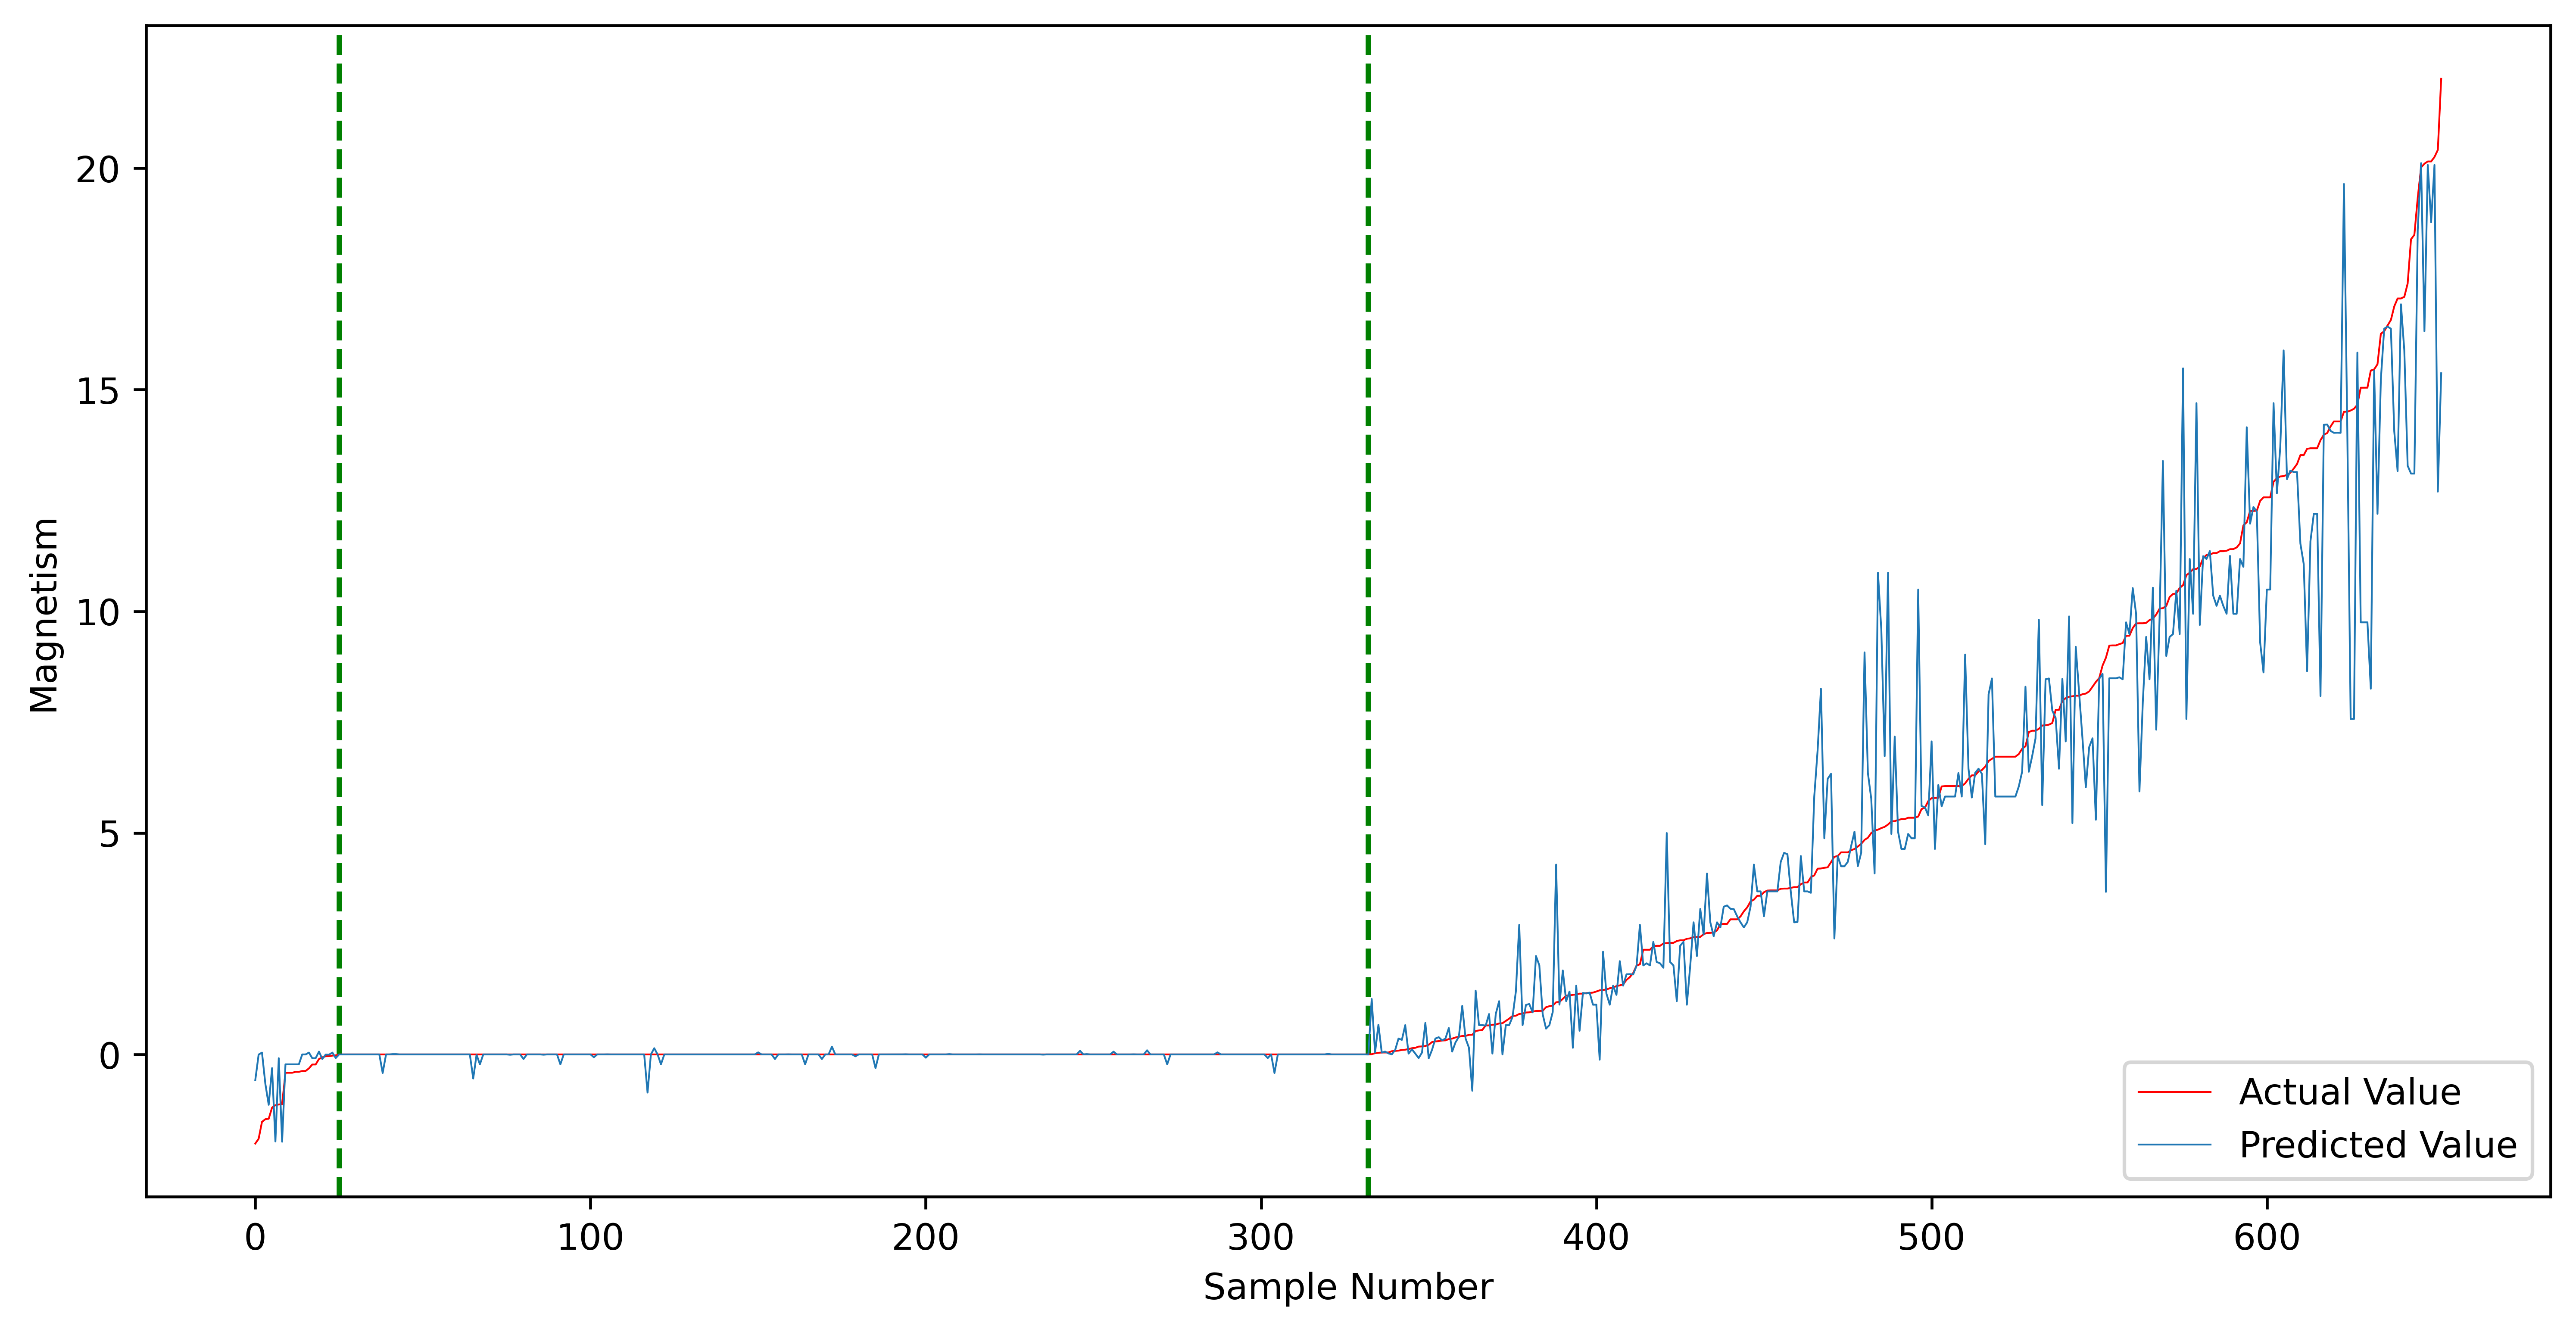

In [140]:
import matplotlib.pyplot as plt

y_test_sorted = [-2.012,-1.903,-1.521,-1.462,-1.452,-1.2,-1.146,-1.129,-1.122,-0.414,-0.414,-0.414,-0.393,-0.393,-0.374,-0.374,-0.315,-0.227,-0.227,-0.104,-0.065,-0.041,-0.039,-0.027,-0.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.002,0.005,0.028,0.037,0.043,0.043,0.045,0.073,0.079,0.086,0.101,0.107,0.122,0.141,0.149,0.177,0.181,0.19,0.218,0.28,0.293,0.3,0.314,0.317,0.347,0.357,0.383,0.398,0.417,0.418,0.442,0.444,0.529,0.542,0.553,0.654,0.655,0.67,0.674,0.699,0.704,0.756,0.808,0.868,0.874,0.913,0.922,0.946,0.95,0.967,0.981,0.983,0.984,1.066,1.089,1.102,1.177,1.187,1.253,1.33,1.33,1.345,1.352,1.372,1.372,1.385,1.388,1.395,1.42,1.447,1.456,1.464,1.494,1.508,1.543,1.558,1.581,1.682,1.746,1.839,2.007,2.033,2.363,2.363,2.363,2.441,2.451,2.451,2.504,2.513,2.518,2.518,2.559,2.576,2.576,2.61,2.62,2.646,2.651,2.652,2.714,2.741,2.743,2.752,2.799,2.939,2.945,2.945,3.049,3.049,3.049,3.113,3.229,3.318,3.453,3.493,3.579,3.581,3.661,3.698,3.702,3.702,3.702,3.738,3.743,3.743,3.759,3.775,3.775,3.84,3.88,3.88,3.999,4.041,4.192,4.196,4.212,4.221,4.339,4.46,4.478,4.56,4.56,4.56,4.608,4.636,4.692,4.751,4.841,4.89,4.997,5.053,5.072,5.108,5.136,5.187,5.261,5.265,5.29,5.31,5.31,5.341,5.341,5.341,5.368,5.537,5.566,5.717,5.783,5.788,5.79,6.048,6.056,6.056,6.056,6.056,6.056,6.056,6.116,6.22,6.298,6.298,6.385,6.417,6.496,6.62,6.671,6.719,6.719,6.719,6.719,6.719,6.719,6.719,6.778,6.896,6.954,7.275,7.305,7.305,7.348,7.422,7.429,7.442,7.479,7.775,7.775,7.976,8.039,8.07,8.082,8.095,8.095,8.129,8.143,8.192,8.299,8.405,8.494,8.776,8.953,9.226,9.23,9.23,9.259,9.283,9.447,9.448,9.621,9.727,9.73,9.73,9.737,9.802,9.833,9.927,10.059,10.071,10.121,10.322,10.39,10.402,10.528,10.589,10.815,10.872,10.95,10.954,11.011,11.2,11.27,11.277,11.314,11.314,11.356,11.356,11.366,11.402,11.403,11.441,11.531,11.939,12.008,12.264,12.264,12.269,12.492,12.571,12.571,12.571,12.923,13.004,13.043,13.05,13.079,13.127,13.218,13.322,13.524,13.524,13.666,13.679,13.679,13.679,13.862,13.986,14.022,14.171,14.284,14.284,14.284,14.503,14.503,14.531,14.57,14.662,15.045,15.045,15.046,15.433,15.458,15.576,16.262,16.319,16.45,16.574,16.88,17.059,17.059,17.096,17.397,18.396,18.497,19.33,20.017,20.1,20.151,20.151,20.252,20.412,22.016]
y_pred_sorted_stacking_lr = [-0.579071080780331,-0.00287549206349206,0.0414997619047619,-0.66275876984127,-1.13699066666667,-0.308632624597624,-1.964477,-0.0846559376478784,-1.96980816666666,-0.223385636955149,-0.223385636955149,-0.223385636955149,-0.223385636955149,-0.223385636955149,0,0,0.0414997619047619,-0.0851547658730159,-0.0851547658730159,0.0640970126262626,-0.103491998376623,-0.00240238095238095,-0.00454027272727273,0.0411682063492063,-0.0817408809523809,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.419181707841178,0,0,0.00671,0.00671,0,0,0,0,0,0,2.84616326386779E-05,0,0,0,0,0,0,0,0,0,0,0,0,2.84616326386779E-05,2.84616326386779E-05,0,-0.544011533230658,-0.0071752380952381,-0.223385636955149,0,0,0,0,0,0,0,0,-0.0071752380952381,2.84616326386779E-05,0,0,-0.103698154593643,0,0,0,0,0,-0.005981,0,0,0,0,-0.223385636955149,0,0,0,0,0,0,0,0,0,-0.0631360630758131,0,0,0,0.00171,0,0,0,0,0,0,0,0,0,0,0,-0.860984416666667,0,0.140502141025641,0,-0.223385636955149,0,0,0,0,0,0,2.84616326386779E-05,0,0,0,-0.00001,0,0,0.000861063603063603,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0466793817016317,0,0,0,0,-0.103491998376623,0,2.84616326386779E-05,0,0.0017,0,0,0,0,-0.223385636955149,0,0,0,0,-0.103698154593643,0,0,0.175760359440267,0,2.84616326386779E-05,0,0,0,0,-0.0423382965367965,0,0,0,0,0,-0.308632624597624,0,0,2.84616326386779E-05,2.84616326386779E-05,-0.000695999999999999,0,0,0.000861063603063603,0.00271230769230769,-0.00001,0,0,0,0,-0.073495207692894,0,0,0,0,0,0,0.00648,0,2.84616326386779E-05,0,0,0,0,0,0,0.00156,2.84616326386779E-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.00404909523809524,0,0,0,0,0,0,0,0,0,0,0.0817819007936508,0,0.00671,0,0,0,0,0,0,-0.00001,0.0633499007104007,0,0,0,0,0,0.00193,0,0,0,0.0935697905908162,0,0,0,0,0,-0.223385636955149,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0466793817016317,0,0,0,0,0,0,0,0,0,0,2.84616326386779E-05,0,0,0,-0.0817408809523809,0,-0.419181707841178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.012124,0,0,2.84616326386779E-05,0,2.84616326386779E-05,2.84616326386779E-05,0,0,0,0,0,-0.00171486220836221,1.25230437085137,0.0411682063492063,0.670476285714285,0.0411682063492063,0.0649865454822955,0.0228488930791431,0.00265380710955711,0.101249477571448,0.359324753760129,0.328596467643468,0.661452122417917,0.018545405047527,0.115497042950514,0.018545405047527,-0.0817408809523809,0.0411682063492063,0.712023211260961,-0.0884550645290382,0.104891261904762,0.359324753760129,0.389195925518926,0.316640523809523,0.359324753760129,0.5965746425761,0.0640970126262626,0.272393880952381,0.398797412698413,1.0956477463925,0.359324753760129,0.152560785714286,-0.820086337717837,1.439069,0.661452122417917,0.661452122417917,0.650939583333333,0.911752901154401,0.0188284737762238,0.911752901154401,1.20179519877345,0,0.661452122417917,0.661452122417917,0.846503397435897,1.4194525,2.92529908974359,0.661452122417917,1.11714265800866,1.13815879401154,0.949551666666666,2.22062583333333,2.01136516666667,0.908351626068376,0.581851714285714,0.661452122417917,0.957916166666666,4.28378713311688,1.12391450757576,1.89499705677656,1.20179519877345,1.4194525,0.150185023809524,1.552424,0.534168761904761,1.38833090530303,1.37605357264957,1.39537494011544,1.1217993523976,1.12391450757576,-0.118257287234043,2.3179036050061,1.37605357264957,1.1217993523976,1.552424,1.3436678008658,2.10513996298146,1.552424,1.80822028210841,1.81171914574478,1.805758124183,2.00110038095238,2.92529908974359,2.00884046117771,2.05658365773116,2.00884046117771,2.5414524047619,2.0861030952381,2.05658365773116,1.95637002676735,4.99630068253968,2.0861030952381,2.00884046117771,1.20179519877345,2.45180434472377,2.5414524047619,1.1217993523976,1.99353932683983,2.98095999586422,2.22062583333333,3.28400730769231,2.70377117674684,4.0818950494228,2.98095999586422,2.66584861327561,2.98095999586422,2.86750107142857,3.33430025163622,3.3623308524531,3.28719686904762,3.28021916666667,3.11835490476191,2.98095999586422,2.86750107142857,2.98095999586422,3.33430025163622,4.28378713311688,3.67961426739353,3.67961426739353,3.11835490476191,3.67961426739353,3.67961426739353,3.67961426739353,3.67961426739353,4.34493163492064,4.54849997619048,4.51850352380952,3.67033676905495,2.98095999586422,2.988526771217,4.47700766971917,3.67961426739353,3.67961426739353,3.64732457323232,5.81940406158533,6.85705249170274,8.25254136239951,4.87798232539683,6.21949913122988,6.33300962012987,2.61679466666667,4.47700766971917,4.24596396031746,4.24596396031746,4.34493163492064,4.70305319047619,5.02595925252525,4.24848379076479,4.55138677128427,9.07273605475896,6.3497053452381,5.77059113131313,4.08338428571429,10.8696918333333,9.58827542621268,6.73166903102452,10.8696918333333,4.97512545670996,7.17232343722944,5.02595925252525,4.63701066314242,4.63701066314242,4.97512545670996,4.87798232539683,4.87798232539683,10.4903250704851,5.60466309911657,5.57906841666666,5.39396078571429,7.06383209720835,4.63701066314242,6.07970946886202,5.59914833333333,5.81940406158533,5.81940406158533,5.81940406158533,5.81940406158533,6.3497053452381,5.81940406158533,9.02535167950032,6.45086475,5.79768826425535,6.35458197727273,6.44760166577867,6.33300962012987,4.74366165800866,8.12612114041514,8.48432129629631,5.81940406158533,5.81940406158533,5.81940406158533,5.81940406158533,5.81940406158533,5.81940406158533,5.81940406158533,6.045250991205,6.37951806313131,8.29783202380952,6.37951806313131,6.73166903102452,7.13373913347763,9.80916648613683,5.62582782223332,8.46638377542487,8.48432129629631,7.75977619696969,7.59517628968254,6.44760166577867,8.4748490952381,7.06383209720835,9.88481302097902,5.21979431746032,9.1995385,8.16326183333333,7.13373913347763,6.02846033053058,6.93437679834054,7.13373913347763,5.29627061280386,8.4774392857143,8.58780670238096,3.66898766666667,8.48820208182254,8.48820208182254,8.48820208182254,8.51016322752248,8.46638377542487,9.75066109523809,9.48916971969696,10.5232858571429,9.94351274713388,5.93606325552315,7.94908667496392,9.42215593650794,8.46638377542487,10.5321187063215,7.32799711484594,9.84943364285714,13.3912590714286,8.9907447520535,9.42215593650794,9.48482088250638,10.4638157085659,9.48482088250638,15.4822535833333,7.57020875000001,11.1805166161616,9.94351274713388,14.6975690427905,9.69210603571428,11.2441371762682,11.1805166161616,11.3588155772561,10.3526266461455,10.123172900761,10.3526266461455,10.123172900761,9.94351274713388,11.2501489242424,9.94351274713388,9.94351274713388,11.1805166161616,11.0030470705128,14.1532282142857,11.9771828572922,12.3527836962482,12.2526991666667,9.3001709937285,8.6214839920635,10.4903250704851,10.4903250704851,14.6975690427905,12.6632096991342,13.7095286111111,15.886855,12.9814472503052,13.1742729233348,13.142393731241,13.142393731241,11.5307768849206,11.0649669832112,8.64757393095793,11.5784031973859,12.1983178387446,12.1983178387446,8.08787902380952,14.2091095079365,14.2152574761905,14.0721536666667,14.02668,14.0299008333333,14.02668,19.6424252261905,14.0628415595238,7.57020875000001,7.57020875000001,15.8380652857143,9.75066109523809,9.75066109523809,9.75066109523809,8.25254136239951,15.4356940641026,12.1983178387446,15.2300676904762,16.3774738095238,16.4243954087302,16.3774738095238,14.0623659404762,13.1633146381674,16.927345,15.886855,13.2844905719676,13.1079351129149,13.1079351129149,18.6078036190476,20.1128321666667,16.3191093333333,20.0725610714286,18.7798466666667,20.0725610714286,12.7002289623571,15.3714934560342]

fig = plt.figure(figsize=(12, 6), dpi=600)
ax = fig.add_subplot(111)

ax.axvline(x=25, color = 'green', linestyle = '--')
ax.axvline(x=332, color = 'green', linestyle = '--')

ax.set_xlabel('Sample Number')
ax.set_ylabel('Magnetism')


ax.plot(y_test_sorted,'r', label = "Actual Value",linewidth=0.5)
ax.plot(y_pred_sorted_stacking_lr, label = "Predicted Value", linewidth=0.5)
ax.legend()

fig.savefig("output_comparison.png", dpi = 600)

In [41]:
import sklearn
sklearn.__version__

'1.0.2'